In [1]:
# Required packages:
import math
import numpy as np
import os
import random
import requests
import json
import bz2
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import wordnet,stopwords
from nltk import word_tokenize, pos_tag
import gensim.downloader as api
from gensim.models import Word2Vec
from itertools import chain
from collections import Counter
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from elasticsearch import Elasticsearch
from elasticsearch import helpers

#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')


### Read query training dataset from Github

Download query from github and split into train set and test set

In [3]:
url = 'https://raw.githubusercontent.com/smart-task/smart-dataset/master/datasets/DBpedia/'
file = 'smarttask_dbpedia_train.json'
url = url + file
queries=requests.get(url).json()


random.seed(a=1234567)
TRAIN_SIZE = int(len(queries) * 0.8)
INDEX_SIZE = int(len(queries) * 0.2)

INDEX_QUERY = queries[:INDEX_SIZE]
TRAIN_QUERY = queries[INDEX_SIZE:TRAIN_SIZE]
TEST_QUERY = queries[TRAIN_SIZE:]
print('number of training query: ',len(TRAIN_QUERY))

TRAIN_QUERY=  [q for q in TRAIN_QUERY if q['category']=='resource']
print('number of resource type query in training:',len(TRAIN_QUERY))

with open('data/test_query.json', 'w') as output:
    json.dump(TEST_QUERY, output)
with open('data/train_query.json', 'w') as output:
    json.dump(TRAIN_QUERY, output)




number of training query:  10542
number of resource type query in training: 5725


Counter({'resource': 7655, 'literal': 4185, 'boolean': 2216})


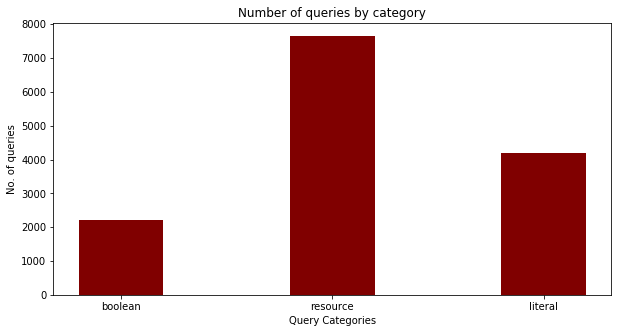

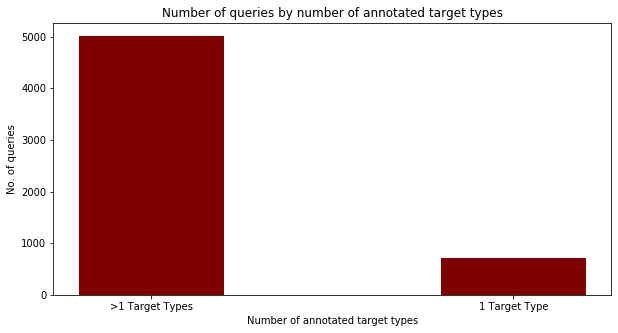

In [4]:
#query stats
TQ = queries[:TRAIN_SIZE]
query_stat = Counter([q['category'] for q in TQ])
print(query_stat)
qt= list(query_stat.keys()) 
ct = list(query_stat.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(qt, ct, color ='maroon',  width = 0.4) 
plt.xlabel("Query Categories") 
plt.ylabel("No. of queries") 
plt.title("Number of queries by category") 
plt.show() 


RQ = [q['type'] for q in TRAIN_QUERY if q['category']=='resource']
#query_stat  = Counter(sum(resource_query,[]))
c0=0
c1=0
 
for q in RQ:
    if len(q)>1: c1 += 1
    else: c0 += 1
        
qt= ['>1 Target Types', '1 Target Type']
ct =[c1,c0]
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(qt, ct, color ='maroon',  width = 0.4) 
plt.xlabel("Number of annotated target types") 
plt.ylabel("No. of queries") 
plt.title("Number of queries by number of annotated target types") 
plt.show() 

### Download file from DBPedia NLP dataset

Check whether dataset files (bz2) are available in data folder and download bz2 file if they are not

In [5]:
dburl= 'http://downloads.dbpedia.org/2016-10/core-i18n/en/'
dbfiles = ['long_abstracts_en.ttl.bz2','instance_types_transitive_en.ttl.bz2']
type_file = 'dbpedia_types.tsv'
dirname = 'data'

for dbfile in dbfiles:
    if not os.path.exists(dirname):
        os.mkdir(dirname) 
    
    # Download file
    if not os.path.exists(dirname + '/' + dbfile):
        url = dburl + dbfile
        r = requests.get(url)
        with open(dirname + '/'+ dbfile, 'wb') as f:
            f.write(r.content)
   
    if not os.path.exists(dirname + '/' + dbfile):

        r = requests.get(url)
        with open(dirname + '/'+ dbfile, 'wb') as f:
            f.write(r.content)

    #extract
    if not os.path.exists(dirname + '/' + dbfile[:-4]):
        filepath= dirname + '/'+ dbfile
        newfilepath = filepath[:-4] 
        with open(filepath, 'rb') as source, open(newfilepath, 'wb') as dest:
            dest.write(bz2.decompress(source.read()))
    else:
        continue
    
url = 'https://raw.githubusercontent.com/smart-task/smart-dataset/master/evaluation/dbpedia/dbpedia_types.tsv'
if not os.path.exists(dirname + '/' + type_file):
    r = requests.get(url)
    with open(dirname + '/'+ type_file, 'wb') as f:
        f.write(r.content)



### Index configuration 

For each of the fields, store the term vectors. These should be stored in the index. 

In [6]:
es = Elasticsearch()
INDEX_NAME_ENTITY = 'nlp_entity'

INDEX_SETTINGS_ENTITY = {
    'mappings': {
            'properties': {
                'description': {
                    'type': 'text',
                    'term_vector': 'yes',
                    'analyzer': 'english'
                },
                'types': {
                    'type': 'text',
                    'term_vector': 'yes',
                    'analyzer': 'english'
                },
            }
        }
    }

INDEX_NAME_TYPE = 'nlp_type'

INDEX_SETTINGS_TYPE = {
    'mappings': {
            'properties': {
                'description': {
                    'type': 'text',
                    'term_vector': 'yes',
                    'analyzer': 'english'
                },
                'question': {
                    'type': 'text',
                    'term_vector': 'yes',
                    'analyzer': 'english'
                },
            }
        }
    }


In [7]:
ABSTRACTS = '<http://dbpedia.org/ontology/abstract>'
COMMENTS = '<http://www.w3.org/2000/01/rdf-schema#comment>'
TYPES = '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
abstract_files = ['long_abstracts_en.ttl']
type_files = ['instance_types_transitive_en.ttl']


In [8]:
def resolve_abstract(text,delimiter):
    text = text.split(delimiter)
    text = text[1].replace('"', '')
    text = text.replace('@en .','')
    return text

def resolve_entity(text):
    name = text.split('>')[0].replace('_', ' ')
    name = name.split('/')[-1]
    return name

def resolve_types(text,delimiter):
    text = text.split(delimiter)
    types = text[1]    
    types = types[types.rfind('/')+1:types.rfind('>')]
    return ['dbo:'+types]

def populate_type(filename,entity_doc):
    #doc structure = {doc: {types: , abstract:}}
    with open(filename,'r',encoding ='utf-8') as bzfin:
        for i, line in enumerate(bzfin):
            #skip header
            if i == 1000000: break
            if i == 0: continue        
            #only consider dbpedia
            if 'dbpedia.org/ontology' in line.lower(): 
                line = line.rstrip()
                entity = resolve_entity(line)
                if entity is not None:
                    if TYPES in line:   
                        types=resolve_types(line,TYPES) 
                        #add value or create new id in dictionary
                        if entity in entity_doc:
                            entity_doc[entity]['types']+= types
                        else:
                            entity_doc[entity]={'types':types}
                        
            
            
    return entity_doc

def populate_abstract(filename, entity_doc):
    #doc structure = {doc: {types: , abstract:}}
    with open(filename, 'r', encoding ='utf-8') as bzfin:
        for i, line in enumerate(bzfin):
            #if i == 1000000: break
            #skip header
            if i == 0: continue      
            #only consider dbpedia, in english
            if 'dbpedia.org/ontology' in line.lower() and 'en' in line.lower():            
                line = line.rstrip()
                entity = resolve_entity(line) 
                if entity is not None:
                    if ABSTRACTS in line:     
                        desc = resolve_abstract(line,ABSTRACTS)
                        if entity in entity_doc:
                            if entity_doc[entity]['types'] is not None:
                                entity_doc[entity]['description']= entity_doc[entity].get('description','') + desc
                            else:                             
                                continue
                        else:
                            continue
            
    return entity_doc

def prepare_doc(type_files,abstract_files):
    entity_doc={}
    type_doc = defaultdict()
    dirname ='data'

    # Download file
    if not os.path.exists(dirname + '/' + 'entity_doc.json'):
        for file in type_files:
            file = dirname + '/'+ file
            entity_doc = populate_type(file,entity_doc)
        print('type files are read')
        for file in abstract_files:
            file = dirname + '/'+ file
            entity_doc = populate_abstract( file,entity_doc)
        print('abstract files are read')
        
        #export to json
        jsn = json.dumps(entity_doc)
        f = open(dirname + '/'+ 'entity_doc.json',"w")
        f.write(jsn)
        f.close()
        print('done populating entity doc')
    else:
        f = open(dirname + '/' + 'entity_doc.json',) 
        entity_doc = json.load(f)
        f.close()
        print('done populating entity doc')
    
    if not os.path.exists(dirname + '/' + 'type_doc.json'):  
        #build type_doc from entity_doc
        print('prepare type_doc')
        for entity in entity_doc:
            types = entity_doc[entity]['types']
            if types is not None:
                for typ in types:
                    if typ in type_doc:
                        type_doc[typ]['description']= type_doc[typ].get('description','') + entity_doc[entity].get('description','')
                    else:
                        type_doc[typ] = {'description': entity_doc[entity].get('description','')}

        #export to json
        jsn = json.dumps(type_doc)
        f = open(dirname+ '/' + 'type_doc.json',"w")
        f.write(jsn)
        f.close()
        print('done populating type doc')
    else:
        f = open(dirname + '/' + 'type_doc.json',) 
        type_doc = json.load(f)
        f.close()
        print('done populating type doc')
        
    return entity_doc, type_doc


def create_index_bulk(INDEX_NAME_ENTITY,INDEX_NAME_TYPE,type_files,abstract_files):   
    entity_docs, type_docs = prepare_doc(type_files,abstract_files)
    action_entity = [
    {
    '_id' : ids,
    "_source" : entity_docs[ids]
    }
    for ids in entity_docs
    ]
    bulk = helpers.bulk(es,action_entity, index = INDEX_NAME_ENTITY, chunk_size=1000, request_timeout=200)
        
    print('entity doc are indexed')
    action_type = [
    {
    '_id' : ids,
    "_source" : type_docs[ids]
    }
    for ids in type_docs
    ]
    bulk = helpers.bulk(es,action_type, index = INDEX_NAME_TYPE, chunk_size=1000, request_timeout=200)
    print('type doc are indexed')

def populate_question(queries, INDEX_NAME_TYPE):
    type_dict = defaultdict(str)
    for query in queries:
        if query['question'] == None:
            continue
        for t in query['type']:
            type_dict[t] += query['question']
    for t, q in type_dict.items():
        if es.exists(index=INDEX_NAME_TYPE, id=t):
            es.update(index=INDEX_NAME_TYPE, id=t, body={"doc":{"question": type_dict[t]}})
        else:
            es.index(index=INDEX_NAME_TYPE, id=t, body={"doc":{"question": type_dict[t]}})
    

## Populate index

Declare two new indexes, one for entity centric model and the other for type centric model

In [10]:
if not es.indices.exists(INDEX_NAME_ENTITY):
    es.indices.create(index=INDEX_NAME_ENTITY, body=INDEX_SETTINGS_ENTITY)    

In [11]:
if not es.indices.exists(INDEX_NAME_TYPE):
    es.indices.create(index=INDEX_NAME_TYPE, body=INDEX_SETTINGS_TYPE)    

In [12]:
create_index_bulk(INDEX_NAME_ENTITY,INDEX_NAME_TYPE,type_files,abstract_files)

done populating entity doc
done populating type doc
entity doc are indexed
type doc are indexed


In [13]:
populate_question(INDEX_QUERY, INDEX_NAME_TYPE)

In [14]:
#check indexes
res = es.get(index='nlp_type', id='dbo:Place')['_source']['description']
print(len(res))
res = es.get(index='nlp_entity', id='Alabama')['_source']['types']
print(res)
count = es.cat.count('nlp_entity', params={"format": "json"})
print(count)
count = es.cat.count('nlp_type', params={"format": "json"})
print(count)

24895113
['dbo:Region', 'dbo:PopulatedPlace', 'dbo:Place', 'dbo:Location']
[{'epoch': '1605469956', 'timestamp': '19:52:36', 'count': '120104'}]
[{'epoch': '1605469956', 'timestamp': '19:52:36', 'count': '255'}]
